## Problem Statement

We have been given a PDE: $u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)=0,\quad x\in[-10,10]$
and boundary condition: $u(x)=\hat{u}(x)$

- Independent variables: x (input)
- Dependent variables: u (outputs)


We have to find out u(x) for all x in range [-10,10] 


When we solved this problem analytically, we found the solution: $u(x) = \sin(0.7x)+\cos(1.5x)-0.1x$


Our residual is $f = u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)$

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [4]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [5]:
use_gpu = torch.cuda.is_available()
print('GPU:', use_gpu)

GPU: True


In [6]:
def is_cuda(data):
    if use_gpu:
        data = data.cuda()
    return data

In [7]:
## PDE residue as loss function.
def f(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x) # the dependent variable u is given by the network based on independent variables x,t
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    pde = u_xx + 0.49*torch.sin(0.7*x) + 2.25*torch.cos(1.5*x)
    return pde

In [8]:
def exact_U(x):
    return np.sin(0.7*x)+np.cos(1.5*x)-0.1*x 

In [9]:
class Model:
    def __init__(self, net, iterations, f, x_bc, u_bc, x_col, exact_u, model_type):
        self.x_bc_s = None
        self.x_f_s = None
        self.s_collect = []
        
        self.f = f        
        self.x_bc = x_bc
        self.u_bc = u_bc
        self.x_col = x_col
        self.exact_u=exact_u
        self.net = net
        self.iterations = iterations
        self.model_type=model_type
        
        self.Step = []
        self.T_error = []
        self.T_BC = []
        self.T_PDE = []
    
    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)
    
    def epoch_loss(self):
        loss_pde = torch.mean(self.f(self.x_col, self.train_U) ** 2)
        loss_bc = torch.mean((self.train_U(self.x_bc) - self.u_bc) ** 2)
        self.T_PDE.append(loss_pde.item())
        self.T_BC.append(loss_bc.item())
        return loss_pde, loss_bc

    def likelihood_loss(self, loss_f, loss_bc):
        loss = torch.exp(-self.x_f_s) * loss_f.detach() + self.x_f_s + torch.exp(-self.x_bc_s) * loss_bc.detach() + self.x_bc_s
        return loss

    def true_loss(self, loss_f, loss_bc):
        loss = torch.exp(-self.x_f_s.detach()) * loss_f + torch.exp(-self.x_bc_s.detach()) * loss_bc 
        return loss
    
    def evaluate(self):
        pred = self.train_U(self.x_col).cpu().detach().numpy()
        exact = self.exact_u.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error
    
    def run_PINN(self):
        self.net.iter=0
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)       
        pbar = trange(self.iterations, ncols=100)

        for i in pbar:            
            loss_pde, loss_bc = self.epoch_loss()    
            optimizer.zero_grad()
            loss = loss_pde + loss_bc
#             loss = self.true_loss(loss_pde,loss_bc)
            loss.backward()
            optimizer.step()
            self.net.iter+=1
            pbar.set_postfix({'Iter': self.net.iter,
                                  'Loss': '{0:.2e}'.format(loss.item()),
                                  'PDE': '{0:.2e}'.format(loss_pde.item()),
                                  'BC': '{0:.2e}'.format(loss_bc.item())
                                  })
            with torch.autograd.no_grad():
                l2_loss = self.evaluate()
                self.T_error.append(l2_loss.item())
                self.Step.append(i)
                
    def run_AW_PINN(self):
        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)
        self.net.iter=0

        optimizer_weight = torch.optim.Adam([self.x_f_s] + [self.x_bc_s],lr=1e-3)
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        
        pbar = trange(self.iterations, ncols=100)

        for i in pbar:
            self.s_collect.append([self.x_f_s.item(), self.x_bc_s.item()])
            
            loss_pde, loss_bc = self.epoch_loss() 
            
            optimizer_weight.zero_grad()
            loss = self.likelihood_loss(loss_pde,loss_bc)
            loss.backward() 
            optimizer_weight.step()
            
            optimizer.zero_grad()
            loss = self.true_loss(loss_pde,loss_bc)
            loss.backward()
            optimizer.step()
            self.net.iter+=1
            pbar.set_postfix({'Iter': self.net.iter,
                                  'Loss': '{0:.2e}'.format(loss.item()),
                                  'PDE': '{0:.2e}'.format(loss_pde.item()),
                                  'BC': '{0:.2e}'.format(loss_bc.item())
                                  })

            
            with torch.autograd.no_grad():
                l2_loss = self.evaluate()
#                 print('[%d]-th step loss: %.4f, s_f:%.4f, s_{bc}:%.4f' % (i, l2_loss, self.x_f_s, self.x_bc_s))
                self.T_error.append(l2_loss.item())
                self.Step.append(i)
        
    def train(self):
        self.x_f_s = is_cuda(torch.tensor(0.).float())
        self.x_bc_s = is_cuda(torch.tensor(0.).float())
        start_time = time.time()
        if self.model_type == 0:
            self.run_PINN()
        elif self.model_type == 1:
            self.run_AW_PINN()

        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

In [10]:
def draw_exact(model):
    x=np.arange(-10,10,0.02).reshape((1000,1)) 
    pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_u = model.predict_U(pt_x)
    plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
    plt.plot(x,exact_U(x), label='exact')
    plt.legend(frameon=False,fontsize=15)
    plt.show()

In [11]:
def draw_error(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.semilogy(model.Step, model.T_error)

    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_2$',fontsize=15)

In [12]:
def draw_epoch_loss(model):
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15)
    plt.semilogy(model.Step, model.T_PDE,'b',label=r'$Loss_{PDE}$')
    plt.semilogy(model.Step, model.T_BC,'r',label=r'$Loss_{BC}$')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$Loss$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [13]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    plt.yscale('log')
    plt.plot(np.array(model.Step), np.exp(-s_collect[:, 0]), 'b-', label=r'$e^{-s_{f}}$')
    plt.plot(np.array(model.Step), np.exp(-s_collect[:, 1]), 'r-', label=r'$e^{-s_{bc}}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\lambda$')
    plt.legend()
    plt.show()

In [14]:
x_bc = np.array([[-10],[10]])
u_bc = exact_U(x_bc)
x_bc=is_cuda(torch.from_numpy(x_bc).float())
u_bc=is_cuda(torch.from_numpy(u_bc).float())

x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
exact_u= exact_U(x_collocation)
x_col=is_cuda(torch.from_numpy(x_collocation).float())
exact_u=is_cuda(torch.from_numpy(exact_u).float())

layers = [1, 50, 50, 50, 1]

# PINN

In [15]:
net = Net(layers)
net = net.to(device)
model_type = 0 # 0:PINN  1:lbPINN
model = Model(
    net=net, iterations = 5000, f=f, x_bc=x_bc, u_bc=u_bc , x_col=x_col, exact_u=exact_u, model_type=model_type)

In [16]:
model.train()

100%|█████| 5000/5000 [00:26<00:00, 190.73it/s, Iter=5000, Loss=4.53e-05, PDE=4.44e-05, BC=8.79e-07]

Training time: 26.22


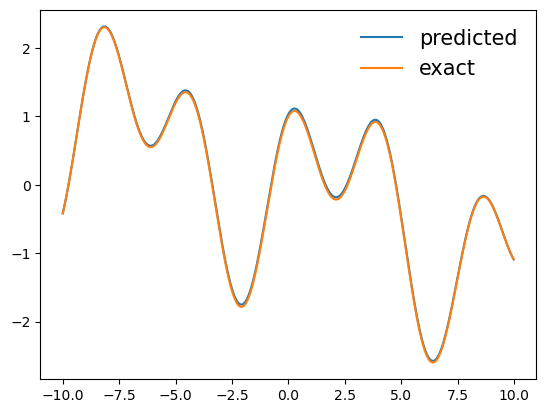

In [17]:
draw_exact(model)

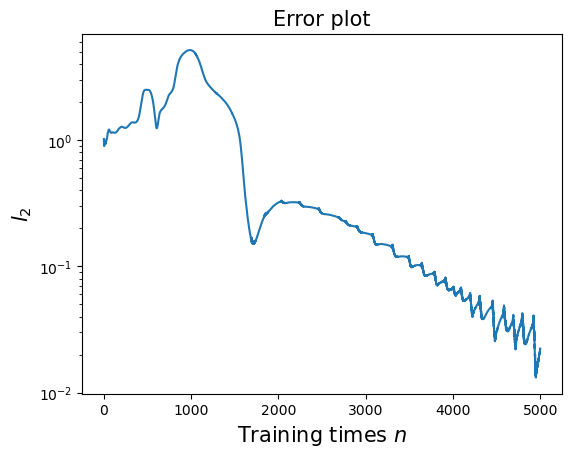

In [18]:
draw_error(model)    

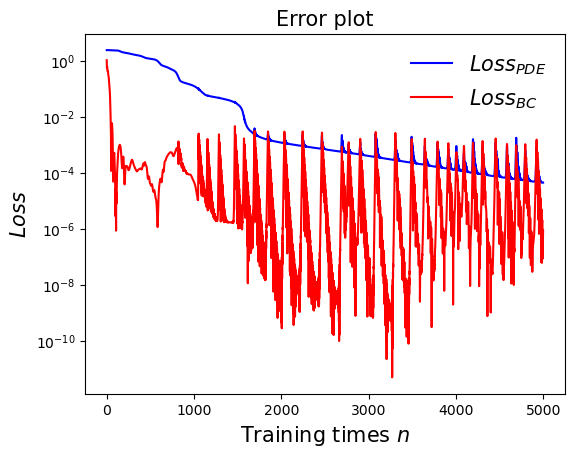

In [19]:
draw_epoch_loss(model)

# lbPINN

In [20]:
net = Net(layers)
net = net.to(device)

model_type = 1 # 0:PINN  1:lbPINN

model1 = Model(
    net=net, iterations = 5000, f=f, x_bc=x_bc, u_bc=u_bc , x_col=x_col, exact_u=exact_u, model_type=model_type)

In [21]:
model1.train()

100%|█████| 5000/5000 [00:29<00:00, 169.38it/s, Iter=5000, Loss=6.23e-03, PDE=6.46e-05, BC=6.24e-08]

Training time: 29.52


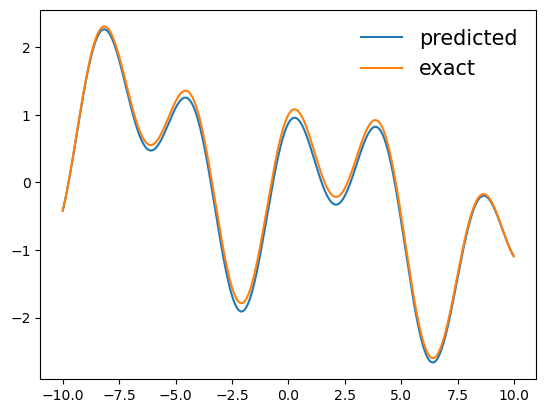

In [22]:
draw_exact(model1)

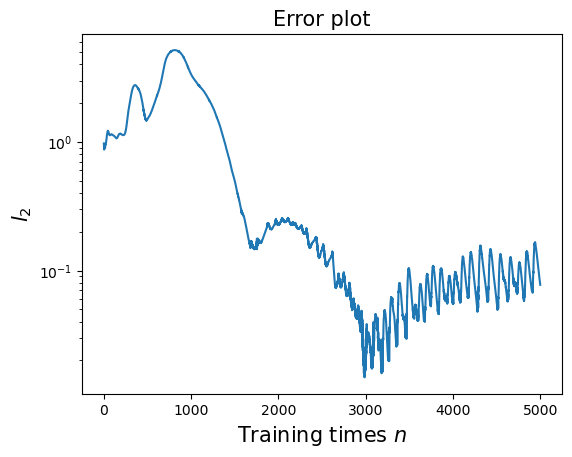

In [23]:
draw_error(model1)

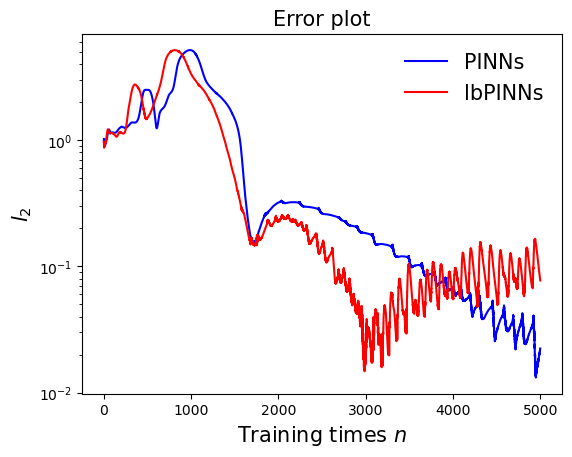

In [24]:
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(model.Step, model.T_error,'b',label='PINNs')
plt.semilogy(model.Step, model1.T_error,'r',label='lbPINNs')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

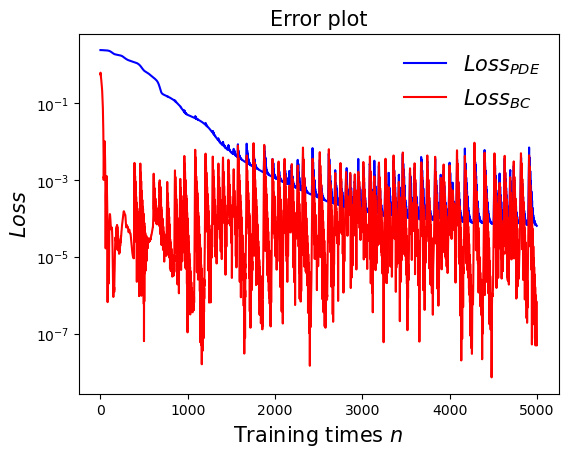

In [25]:
draw_epoch_loss(model1)

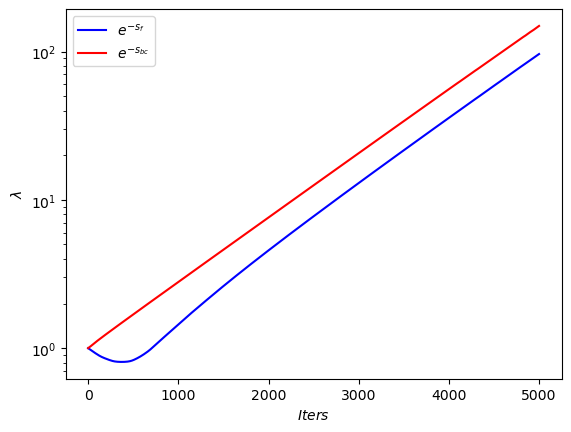

In [26]:
draw_epoch_w(model1)